In [1]:
%load_ext autoreload
%autoreload 2

## Shape analysis

The goal is to have a generalized algorithm that for all symmetrically equivalent cluster centers, find nearest atoms from trajectory, and transforms them back to the asymmetric unit. This helps the statistics for performing shape analysis and making plots.

As input:

1. crystal or material structure
    - contains cluster centers
    - includes symmetry operations
2. trajectory
    - typically P1
    - maybe a supercell of crystal structure
    - lattice can be triclinic (non-constrained in simulation)

Algorithm:

1. load clusters (pymatgen structure)
2. load trajectory (pymatgen trajectory)
3. reduce supercell of trajectory to match clusters
    - assert trajectory and cluster lattices match
4. for every unique cluster center, 
    5. for every symmetry operation
    - apply next symmetry operation to cluster center
    - find all trajectory points within X distance
    - copy and map points back to asymmetric unit (reverse symmetry op)
    - subtract cluster center coords
10. perform shape analysis
    - plots, fits, heat maps, msd, etc
   
See: https://github.com/GEMDAT-repos/GEMDAT/pull/166

In [10]:
from __future__ import annotations

from pathlib import Path

import numpy as np

from gemdat import Trajectory
from gemdat.io import read_cif

trajectory = Trajectory.from_vasprun(
    Path(
        '/home/stef/md-analysis-matlab-example-short/shape_analysis/vasprun.xml'
    ))

supercell = (2, 1, 1)

diff_trajectory = trajectory.filter('Li')[:1000]

# structure = load_known_material('argyrodite')
structure = read_cif(
    '/home/stef/md-analysis-matlab-example-short/shape_analysis/argyrodite_48h48h16e.cif'
)

In [11]:
diff_trajectory.get_lattice(0)

Lattice
    abc : 19.84771 9.923855 9.923855
 angles : 90.0 90.0 90.0
 volume : 1954.6600006747865
      A : 19.84771 0.0 0.0
      B : 0.0 9.923855 0.0
      C : 0.0 0.0 9.923855
    pbc : True True True

In [12]:
# collapse coords
positions = diff_trajectory.positions.reshape(-1, 3)
positions, positions.shape

(array([[0.16145033, 0.33547197, 0.02452775],
        [0.10760483, 0.71007687, 0.50529059],
        [0.37023313, 0.71662174, 0.00237432],
        ...,
        [0.56668228, 0.65263625, 0.49765395],
        [0.8561833 , 0.99886925, 0.36625886],
        [0.84988794, 0.49014067, 0.83681645]]),
 (48000, 3))

In [13]:
# collapse supercell
positions = np.mod(positions, 1 / np.array(supercell)) * np.array(supercell)
positions, positions.shape

(array([[0.32290066, 0.33547197, 0.02452775],
        [0.21520966, 0.71007687, 0.50529059],
        [0.74046626, 0.71662174, 0.00237432],
        ...,
        [0.13336456, 0.65263625, 0.49765395],
        [0.7123666 , 0.99886925, 0.36625886],
        [0.69977588, 0.49014067, 0.83681645]]),
 (48000, 3))

In [14]:
from pymatgen import symmetry

sga = symmetry.analyzer.SpacegroupAnalyzer(structure)

symops = sga.get_space_group_operations()
symstruct = sga.get_symmetrized_structure()
lattice = symstruct.lattice
lattice

Lattice
    abc : 9.924 9.924 9.924
 angles : 90.0 90.0 90.0
 volume : 977.3728410239999
      A : 9.924 0.0 6.076697417369166e-16
      B : 1.5959009175390938e-15 9.924 6.076697417369166e-16
      C : 0.0 0.0 9.924
    pbc : True True True

In [15]:
unique_sites = [sites[0] for sites in symstruct.equivalent_sites]
unique_sites

[PeriodicSite: 48h (Li) (1.816, 1.816, 0.2382) [0.183, 0.183, 0.024],
 PeriodicSite: 48h2 (Li) (0.7939, 0.7939, 1.816) [0.08, 0.08, 0.183],
 PeriodicSite: 16e (Li) (8.535, 8.535, 8.535) [0.86, 0.86, 0.86]]

## TODO

- [ ] Load sites from cif
- [ ] Loop over unique coords
- [ ] Store cluster per unique label
- [ ] seaborn plot
- [ ] density plot

In [16]:
thresh = 1.0  # Å

clusters = {}

for site in unique_sites:
    print(f'\n{site.label}: {site.frac_coords}\n')

    unq_coord = site.frac_coords
    cluster = []

    for op in symops:
        cluster_coord = op.operate(unq_coord)
        dists = lattice.get_all_distances(cluster_coord, positions)

        sel = dists < thresh
        close = positions[sel.flatten()]

        # digitize differences to move all close positions to
        # same sphere around cluster center
        offsets = np.digitize(close - cluster_coord, bins=[0.5, -0.4999999
                                                           ]) - 1

        close += offsets

        inversed = op.inverse.operate_multi(close)

        print(f'size: {len(inversed)}', end=', ')
        print('mean: {: .3f} {: .3f} {: .3f}'.format(*inversed.mean(axis=0)))

        cluster.append(inversed)

    clusters[site.label] = np.vstack(cluster) - unq_coord


48h: [0.183 0.183 0.024]

size: 1339, mean:  0.200  0.183  0.020
size: 1215, mean:  0.181  0.212  0.020
size: 1205, mean:  0.199  0.185  0.022
size: 1084, mean:  0.186  0.202  0.029
size: 1215, mean:  0.212  0.181  0.020
size: 1339, mean:  0.183  0.200  0.020
size: 1084, mean:  0.202  0.186  0.029
size: 1205, mean:  0.185  0.199  0.022
size: 580, mean:  0.207  0.167  0.041
size: 1471, mean:  0.199  0.187  0.037
size: 1244, mean:  0.151  0.200  0.029
size: 804, mean:  0.200  0.189  0.009
size: 1471, mean:  0.187  0.199  0.037
size: 580, mean:  0.167  0.207  0.041
size: 804, mean:  0.189  0.200  0.009
size: 1244, mean:  0.200  0.151  0.029
size: 509, mean:  0.207  0.207  0.038
size: 515, mean:  0.203  0.188  0.016
size: 0, mean:  nan  nan  nan
size: 0, mean:  nan  nan  nan
size: 515, mean:  0.188  0.203  0.016
size: 509, mean:  0.207  0.207  0.038
size: 0, mean:  nan  nan  nan
size: 0, mean:  nan  nan  nan
size: 789, mean:  0.210  0.204  0.032


/tmp/ipykernel_544846/836357836.py:28: RuntimeWarning: Mean of empty slice.
  print('mean: {: .3f} {: .3f} {: .3f}'.format(*inversed.mean(axis=0)))
/home/stef/python/gemdat/.venv/lib64/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


size: 924, mean:  0.176  0.207  0.034
size: 322, mean:  0.188  0.207  0.001
size: 612, mean:  0.209  0.209  0.019
size: 924, mean:  0.207  0.176  0.034
size: 789, mean:  0.204  0.210  0.032
size: 612, mean:  0.209  0.209  0.019
size: 322, mean:  0.207  0.188  0.001
size: 356, mean:  0.177  0.178  0.046
size: 918, mean:  0.192  0.180  0.012
size: 1436, mean:  0.203  0.187  0.020
size: 914, mean:  0.186  0.169  0.016
size: 918, mean:  0.180  0.192  0.012
size: 356, mean:  0.178  0.177  0.046
size: 914, mean:  0.169  0.186  0.016
size: 1436, mean:  0.187  0.203  0.020
size: 158, mean:  0.184  0.202  0.048
size: 939, mean:  0.164  0.170  0.030
size: 794, mean:  0.183  0.154  0.039
size: 828, mean:  0.220  0.192  0.019
size: 939, mean:  0.170  0.164  0.030
size: 158, mean:  0.202  0.184  0.048
size: 828, mean:  0.192  0.220  0.019
size: 794, mean:  0.154  0.183  0.039
size: 493, mean:  0.185  0.212  0.003
size: 198, mean:  0.210  0.153  0.044
size: 251, mean:  0.168  0.223  0.036
size: 516,

48h  MSD (A^2) =  0.36177784356071785  std =  0.26344407393362523


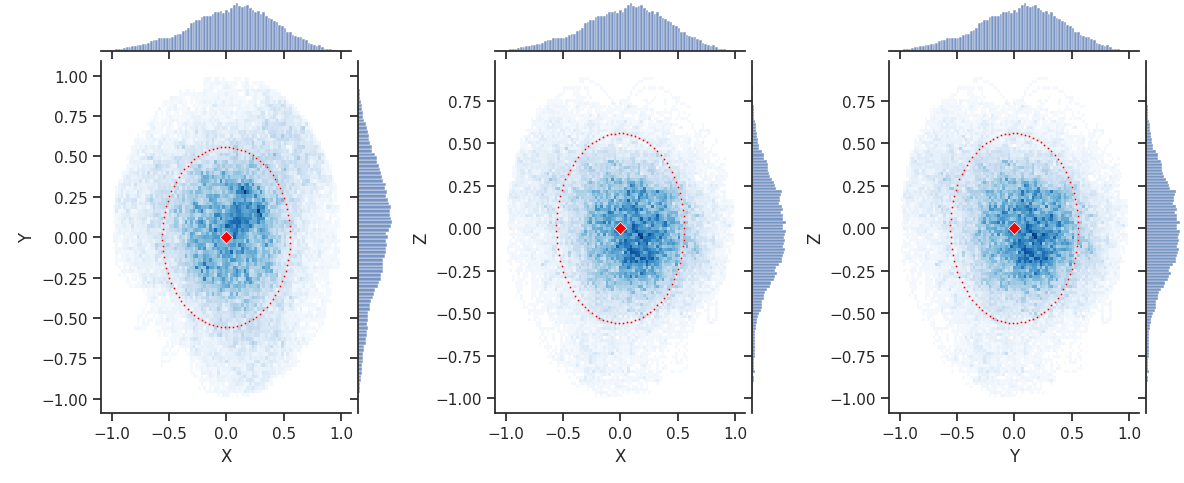

48h2  MSD (A^2) =  0.5571727546581038  std =  0.2805146941553308


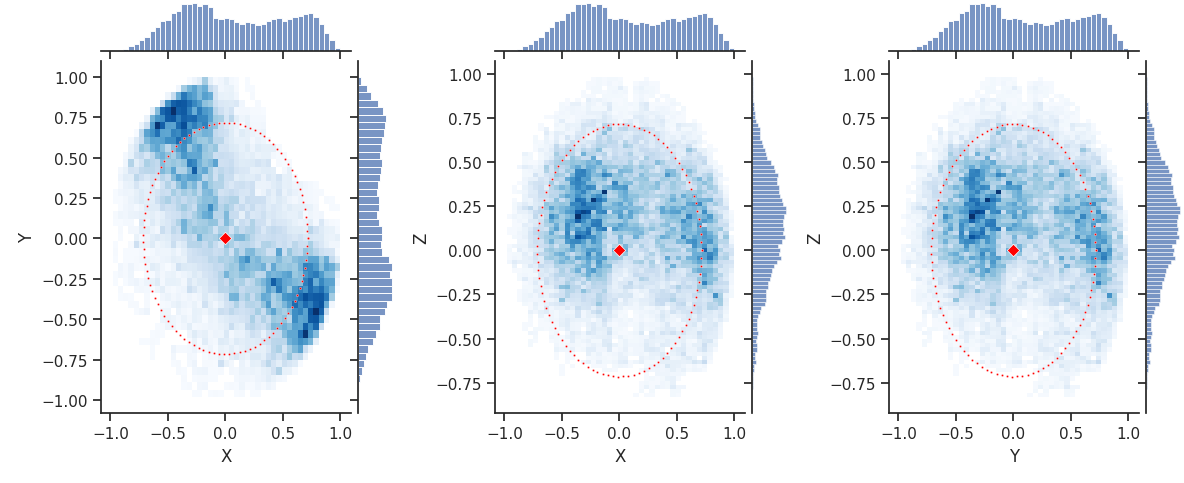

16e  MSD (A^2) =  0.5492818788569054  std =  0.2692917787014663


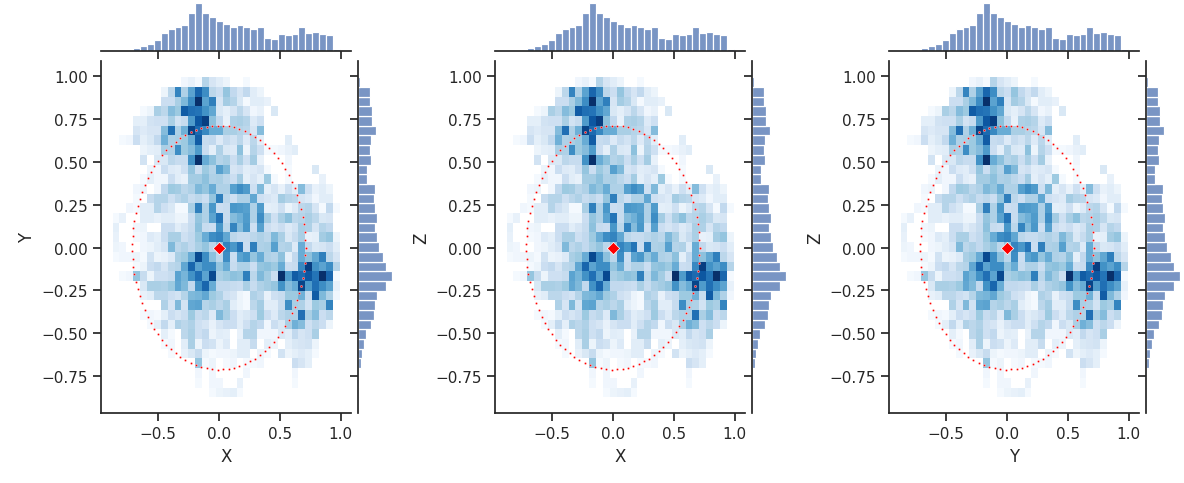

In [51]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()


class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig, subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(
            n, m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i, j], self.subgrid[i, j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h = self.sg.ax_joint.get_position().height
        h2 = self.sg.ax_marg_x.get_position().height
        r = int(np.round(h / h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(
            r + 1, r + 1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure = self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


color_palette = sns.color_palette()
sns.set_palette(color_palette)
sns.set_style("ticks")

for i, (label, cluster) in enumerate(clusters.items()):
    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(1, 3)

    cart_coords = lattice.get_cartesian_coords(cluster)
    distances = np.sum(cart_coords**2, axis=1)**0.5
    print(label, ' MSD (A^2) = ', np.mean(distances**2), ' std = ',
          np.std(distances**2))

    theta = np.linspace(0, 2 * np.pi, 100)  # 100 points around the circle
    x_circle = 0 + np.mean(distances) * np.cos(theta)
    y_circle = 0 + np.mean(distances) * np.sin(theta)

    for j, (axis_i, axis_j) in enumerate(((0, 1), (0, 2), (1, 2))):
        g1 = sns.jointplot(x=cart_coords[:, axis_i],
                           y=cart_coords[:, axis_j],
                           kind='hist',
                           fill=True,
                           cmap='Blues')
        sns.scatterplot(x=[0],
                        y=[0],
                        marker='D',
                        s=40,
                        color='red',
                        ax=g1.ax_joint)
        sns.scatterplot(x=x_circle,
                        y=y_circle,
                        marker='.',
                        s=10,
                        color='red',
                        ax=g1.ax_joint)

        g1.ax_joint.set_xlabel('XYZ'[axis_i])
        g1.ax_joint.set_ylabel('XYZ'[axis_j])

        SeabornFig2Grid(g1, fig, gs[0, j])

    gs.tight_layout(fig)
    plt.show()

In [47]:
cart_coords[:, 1]

array([-0.04885942, -0.04422303, -0.04425945, ..., -0.3617562 ,
       -0.35394482, -0.34136   ])

In [48]:
cart_coords[:, 0]

array([0.86964588, 0.87122895, 0.87523904, ..., 0.05299912, 0.04408122,
       0.0346824 ])

In [49]:
cart_coords[:, 2]

array([-0.46599462, -0.43257059, -0.40428997, ...,  0.90542557,
        0.91919939,  0.93522903])